In [1]:
!pip install nltk spacy wordcloud textstat
!python -m spacy download en_core_web_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 55.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 100.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [4]:
import nltk
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter, defaultdict
import re
import string
from textstat import flesch_reading_ease, flesch_kincaid_grade
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Downloading the NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('vader_lexicon')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [6]:
nlp = spacy.load('en_core_web_sm')
print("All libraries installed and loaded successfully!")

All libraries installed and loaded successfully!


In [7]:
# sample data for analysis
sample_texts = {
    "news_article": """
    Apple Inc. reported record quarterly revenue of $123.9 billion for the first quarter of 2024,
    driven by strong iPhone sales in China and emerging markets. CEO Tim Cook announced the company's
    continued investment in artificial intelligence and renewable energy initiatives. The tech giant
    also revealed plans to expand its manufacturing operations in India and Vietnam by 2025.
    """,

    "social_media": """
    Just had the most amazing pizza at Tony's Restaurant in New York! 🍕 The margherita was incredible
    and the service was fantastic. Definitely recommend this place to anyone visiting NYC.
    #pizza #foodie #newyork #recommendation
    """,

    "academic_text": """
    Natural Language Processing (NLP) is a subfield of artificial intelligence that focuses on the
    interaction between computers and human language. It involves developing algorithms and models
    that can understand, interpret, and generate human language in a valuable way. Key applications
    include machine translation, sentiment analysis, and question-answering systems.
    """
}


print("Sample texts loaded for analysis:")
for key, text in sample_texts.items():
  print(f"\n{key.upper():}")
  print(text.strip()[:100] + "...")

Sample texts loaded for analysis:

NEWS_ARTICLE
Apple Inc. reported record quarterly revenue of $123.9 billion for the first quarter of 2024, 
    d...

SOCIAL_MEDIA
Just had the most amazing pizza at Tony's Restaurant in New York! 🍕 The margherita was incredible 
 ...

ACADEMIC_TEXT
Natural Language Processing (NLP) is a subfield of artificial intelligence that focuses on the 
    ...


In [10]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [11]:
# 1. Text Preprocessing pipeline

class TextPreprocessor:
    """
    A comprehensive text preprocessing class that demonstrates core NLP concepts
    """

    def __init__(self):
        # Load NLTK components
        from nltk.corpus import stopwords
        from nltk.stem import PorterStemmer
        from nltk.stem import WordNetLemmatizer

        self.stop_words = set(stopwords.words('english'))
        self.stemmer = PorterStemmer()
        self.lemmatizer = WordNetLemmatizer()

    def clean_text(self, text):
        """
        CONCEPT: Text Cleaning
        - Removes URLs, mentions, hashtags (for social media)
        - Handles special characters and extra whitespace
        """
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        # Remove mentions and hashtags
        text = re.sub(r'@\w+|#\w+', '', text)
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    def to_lowercase(self, text):
        """
        CONCEPT: Case Normalization
        - Ensures consistent processing (Apple = apple)
        - Reduces vocabulary size
        """
        return text.lower()

    def remove_punctuation(self, text):
        """
        CONCEPT: Punctuation Removal
        - Removes punctuation marks for word-level analysis
        - Preserves sentence structure when needed
        """
        return text.translate(str.maketrans('', '', string.punctuation))

    def tokenize_sentences(self, text):
        """
        CONCEPT: Sentence Tokenization
        - Splits text into individual sentences
        - Handles abbreviations and decimal numbers
        """
        from nltk.tokenize import sent_tokenize
        return sent_tokenize(text)

    def tokenize_words(self, text):
        """
        CONCEPT: Word Tokenization
        - Splits text into individual words/tokens
        - Handles contractions and punctuation
        """
        from nltk.tokenize import word_tokenize
        return word_tokenize(text)

    def remove_stopwords(self, tokens):
        """
        CONCEPT: Stop Word Removal
        - Removes common words that don't carry much meaning
        - Examples: the, is, at, which, on
        """
        return [token for token in tokens if token.lower() not in self.stop_words]

    def stem_words(self, tokens):
        """
        CONCEPT: Stemming
        - Reduces words to their root form using rules
        - Fast but sometimes inaccurate (studies → studi)
        """
        return [self.stemmer.stem(token) for token in tokens]

    def lemmatize_words(self, tokens):
        """
        CONCEPT: Lemmatization
        - Reduces words to their dictionary form using linguistic knowledge
        - More accurate but slower than stemming (better → good)
        """
        return [self.lemmatizer.lemmatize(token) for token in tokens]

    def preprocess_pipeline(self, text, steps=['clean', 'lowercase', 'tokenize', 'remove_stopwords']):
        """
        Complete preprocessing pipeline with customizable steps
        """
        result = {'original': text}

        if 'clean' in steps:
            text = self.clean_text(text)
            result['cleaned'] = text

        if 'lowercase' in steps:
            text = self.to_lowercase(text)
            result['lowercased'] = text

        if 'tokenize' in steps:
            tokens = self.tokenize_words(text)
            result['tokens'] = tokens
            text = tokens  # Continue with tokens

        if 'remove_punctuation' in steps and isinstance(text, str):
            text = self.remove_punctuation(text)
            result['no_punctuation'] = text

        if 'remove_stopwords' in steps and isinstance(text, list):
            text = self.remove_stopwords(text)
            result['no_stopwords'] = text

        if 'stem' in steps and isinstance(text, list):
            stemmed = self.stem_words(text)
            result['stemmed'] = stemmed

        if 'lemmatize' in steps and isinstance(text, list):
            lemmatized = self.lemmatize_words(text)
            result['lemmatized'] = lemmatized

        return result

# Initialize preprocessor
preprocessor = TextPreprocessor()

# Demonstrate preprocessing pipeline
print("🔧 TEXT PREPROCESSING DEMONSTRATION")
print("="*50)

sample_text = sample_texts['social_media']
print(f"Original text:\n{sample_text}\n")

# Show each preprocessing step
steps = ['clean', 'lowercase', 'tokenize', 'remove_stopwords', 'lemmatize']
result = preprocessor.preprocess_pipeline(sample_text, steps)

for step, processed_text in result.items():
    if step != 'original':
        print(f"{step.upper()}:")
        if isinstance(processed_text, list):
            print(f"{processed_text[:10]}..." if len(processed_text) > 10 else processed_text)
        else:
            print(processed_text[:100] + "..." if len(processed_text) > 100 else processed_text)
        print()

🔧 TEXT PREPROCESSING DEMONSTRATION
Original text:

    Just had the most amazing pizza at Tony's Restaurant in New York! 🍕 The margherita was incredible 
    and the service was fantastic. Definitely recommend this place to anyone visiting NYC. 
    #pizza #foodie #newyork #recommendation
    

CLEANED:
Just had the most amazing pizza at Tony's Restaurant in New York! 🍕 The margherita was incredible an...

LOWERCASED:
just had the most amazing pizza at tony's restaurant in new york! 🍕 the margherita was incredible an...

TOKENS:
['just', 'had', 'the', 'most', 'amazing', 'pizza', 'at', 'tony', "'s", 'restaurant']...

NO_STOPWORDS:
['amazing', 'pizza', 'tony', "'s", 'restaurant', 'new', 'york', '!', '🍕', 'margherita']...

LEMMATIZED:
['amazing', 'pizza', 'tony', "'s", 'restaurant', 'new', 'york', '!', '🍕', 'margherita']...



In [12]:
# 2. TOKENIZATION ANALYSIS
# =============================================================================

def analyze_tokenization(text):
    """
    CONCEPT: Understanding Tokenization
    - Compare sentence vs word tokenization
    - Analyze token statistics
    """
    print("📊 TOKENIZATION ANALYSIS")
    print("="*50)

    # Sentence tokenization
    sentences = preprocessor.tokenize_sentences(text)
    print(f"Number of sentences: {len(sentences)}")
    print(f"Sentences:")
    for i, sent in enumerate(sentences, 1):
        print(f"  {i}. {sent.strip()}")
    print()

    # Word tokenization
    words = preprocessor.tokenize_words(text)
    print(f"Number of words: {len(words)}")
    print(f"First 15 words: {words[:15]}")
    print()

    # Token statistics
    unique_words = set(word.lower() for word in words if word.isalpha())
    print(f"Unique words: {len(unique_words)}")
    print(f"Vocabulary richness: {len(unique_words)/len(words):.2f}")

    return sentences, words

# Analyze tokenization for news article
sentences, words = analyze_tokenization(sample_texts['news_article'])

📊 TOKENIZATION ANALYSIS
Number of sentences: 3
Sentences:
  1. Apple Inc. reported record quarterly revenue of $123.9 billion for the first quarter of 2024, 
    driven by strong iPhone sales in China and emerging markets.
  2. CEO Tim Cook announced the company's 
    continued investment in artificial intelligence and renewable energy initiatives.
  3. The tech giant 
    also revealed plans to expand its manufacturing operations in India and Vietnam by 2025.

Number of words: 63
First 15 words: ['Apple', 'Inc.', 'reported', 'record', 'quarterly', 'revenue', 'of', '$', '123.9', 'billion', 'for', 'the', 'first', 'quarter', 'of']

Unique words: 45
Vocabulary richness: 0.71


In [13]:
# 3. PART-OF-SPEECH (POS) TAGGING
# =============================================================================

def analyze_pos_tags(text):
    """
    CONCEPT: Part-of-Speech Tagging
    - Identifies grammatical role of each word
    - Helps understand sentence structure
    """
    print("\n🏷️ PART-OF-SPEECH TAGGING ANALYSIS")
    print("="*50)

    # Using NLTK for POS tagging
    from nltk import pos_tag

    tokens = preprocessor.tokenize_words(text)
    pos_tags = pos_tag(tokens)

    print("Word → POS Tag:")
    for word, tag in pos_tags[:15]:  # Show first 15
        tag_meaning = {
            'NN': 'Noun (singular)', 'NNS': 'Noun (plural)', 'NNP': 'Proper noun (singular)',
            'VB': 'Verb (base form)', 'VBD': 'Verb (past tense)', 'VBG': 'Verb (gerund)',
            'JJ': 'Adjective', 'JJR': 'Adjective (comparative)', 'JJS': 'Adjective (superlative)',
            'RB': 'Adverb', 'DT': 'Determiner', 'IN': 'Preposition', 'CC': 'Conjunction',
            'PRP': 'Pronoun', 'CD': 'Cardinal number'
        }.get(tag, tag)
        print(f"  {word} → {tag} ({tag_meaning})")

    # POS tag frequency analysis
    tag_freq = Counter(tag for word, tag in pos_tags)
    print(f"\nMost common POS tags:")
    for tag, count in tag_freq.most_common(5):
        print(f"  {tag}: {count}")

    # Visualize POS distribution
    plt.figure(figsize=(10, 6))
    tags, counts = zip(*tag_freq.most_common(10))
    plt.bar(tags, counts)
    plt.title('Part-of-Speech Tag Distribution')
    plt.xlabel('POS Tags')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return pos_tags

# Analyze POS tags for academic text
pos_results = analyze_pos_tags(sample_texts['academic_text'])


🏷️ PART-OF-SPEECH TAGGING ANALYSIS


LookupError: 
**********************************************************************
  Resource [93maveraged_perceptron_tagger_eng[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtaggers/averaged_perceptron_tagger_eng/[0m

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************



🎯 NAMED ENTITY RECOGNITION
Identified entities:
  Apple Inc. → ORG (Companies, agencies, institutions, etc.)
  quarterly → DATE (Absolute or relative dates or periods)
  $123.9 billion → MONEY (Monetary values, including unit)
  the first quarter of 2024 → DATE (Absolute or relative dates or periods)
  China → GPE (Countries, cities, states)
  Tim Cook → PERSON (People, including fictional)
  India → GPE (Countries, cities, states)
  Vietnam → GPE (Countries, cities, states)
  2025 → DATE (Absolute or relative dates or periods)

Entities by type:
  ORG: Apple Inc.
  DATE: quarterly, the first quarter of 2024, 2025
  MONEY: $123.9 billion
  GPE: China, India, Vietnam
  PERSON: Tim Cook


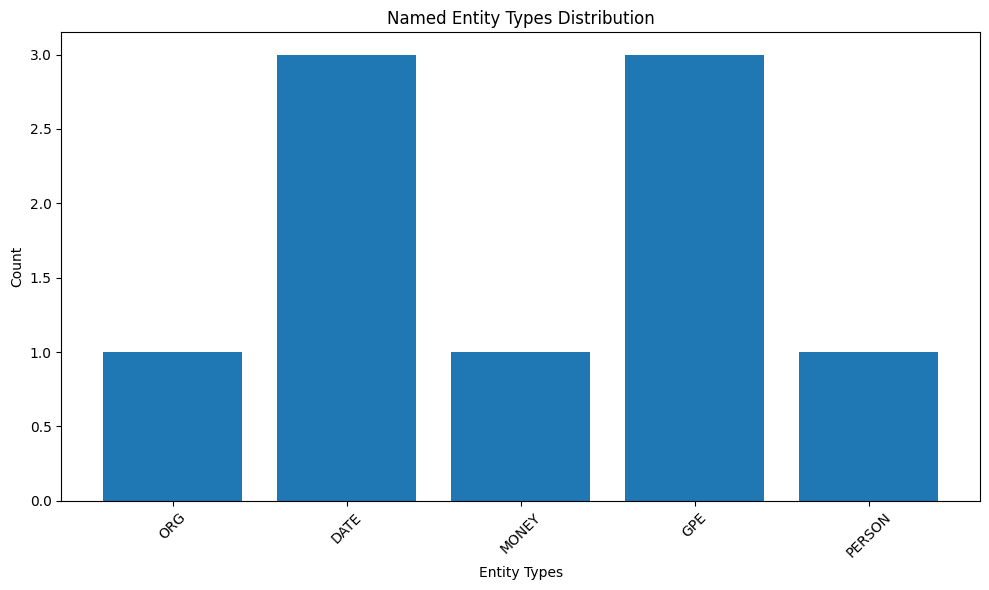

In [14]:
# 4. NAMED ENTITY RECOGNITION (NER)
# =============================================================================

def analyze_named_entities(text):
    """
    CONCEPT: Named Entity Recognition
    - Identifies proper nouns and their categories
    - Extracts people, places, organizations, dates, etc.
    """
    print("\n🎯 NAMED ENTITY RECOGNITION")
    print("="*50)

    # Using spaCy for NER
    doc = nlp(text)

    entities = [(ent.text, ent.label_, spacy.explain(ent.label_)) for ent in doc.ents]

    if entities:
        print("Identified entities:")
        for entity, label, description in entities:
            print(f"  {entity} → {label} ({description})")

        # Group entities by type
        entity_types = defaultdict(list)
        for entity, label, _ in entities:
            entity_types[label].append(entity)

        print(f"\nEntities by type:")
        for ent_type, ents in entity_types.items():
            print(f"  {ent_type}: {', '.join(ents)}")

        # Visualize entity types
        if len(entity_types) > 1:
            plt.figure(figsize=(10, 6))
            types, counts = zip(*[(t, len(e)) for t, e in entity_types.items()])
            plt.bar(types, counts)
            plt.title('Named Entity Types Distribution')
            plt.xlabel('Entity Types')
            plt.ylabel('Count')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
    else:
        print("No named entities found in this text.")

    return entities

# Analyze named entities in news article
ner_results = analyze_named_entities(sample_texts['news_article'])


ANALYZING: NEWS_ARTICLE

📈 WORD FREQUENCY ANALYSIS
Most common words:
  .: 3
  apple: 1
  inc.: 1
  reported: 1
  record: 1
  quarterly: 1
  revenue: 1
  $: 1
  123.9: 1
  billion: 1
  first: 1
  quarter: 1
  2024: 1
  ,: 1
  driven: 1


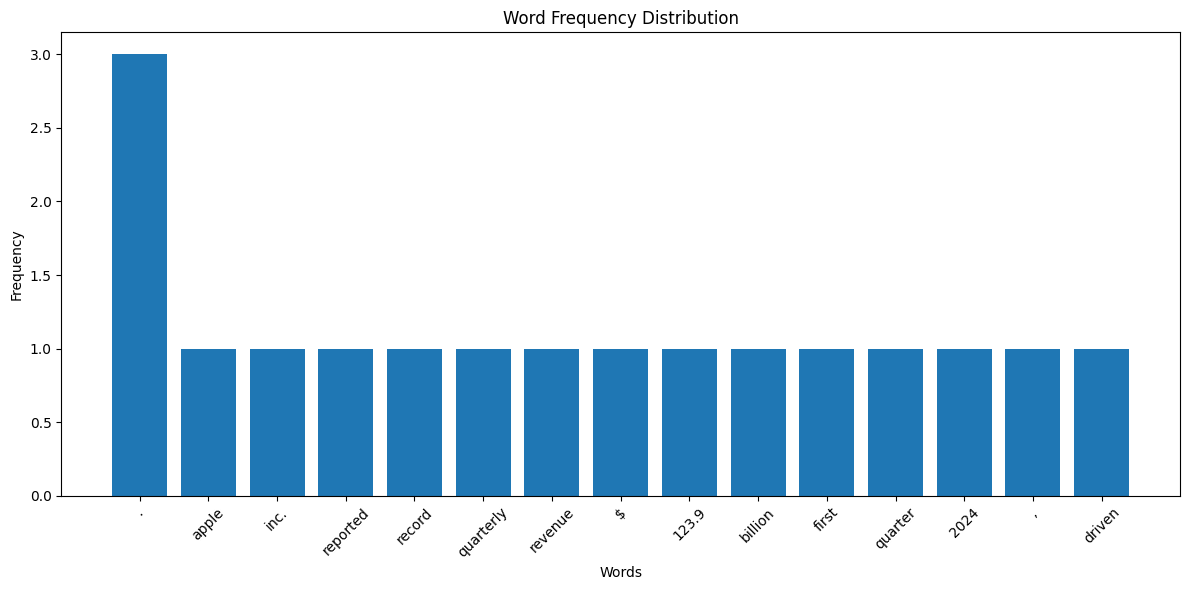

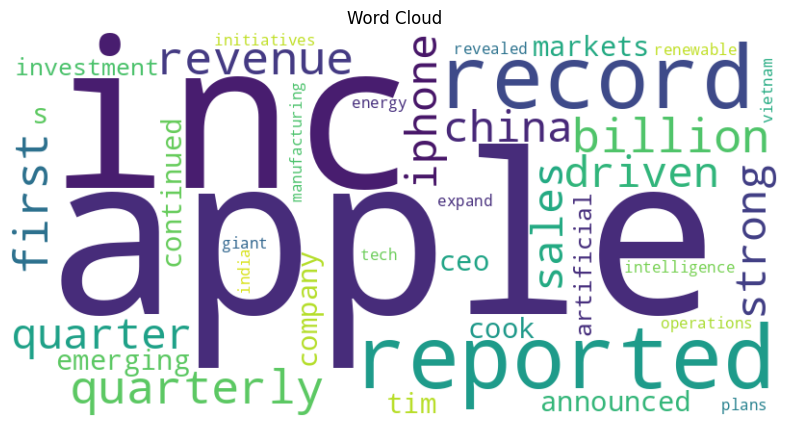


🔗 2-GRAM ANALYSIS
Most common 2-grams:
  apple inc.: 1
  inc. reported: 1
  reported record: 1
  record quarterly: 1
  quarterly revenue: 1

ANALYZING: SOCIAL_MEDIA

📈 WORD FREQUENCY ANALYSIS
Most common words:
  .: 2
  amazing: 1
  pizza: 1
  tony: 1
  's: 1
  restaurant: 1
  new: 1
  york: 1
  !: 1
  🍕: 1
  margherita: 1
  incredible: 1
  service: 1
  fantastic: 1
  definitely: 1


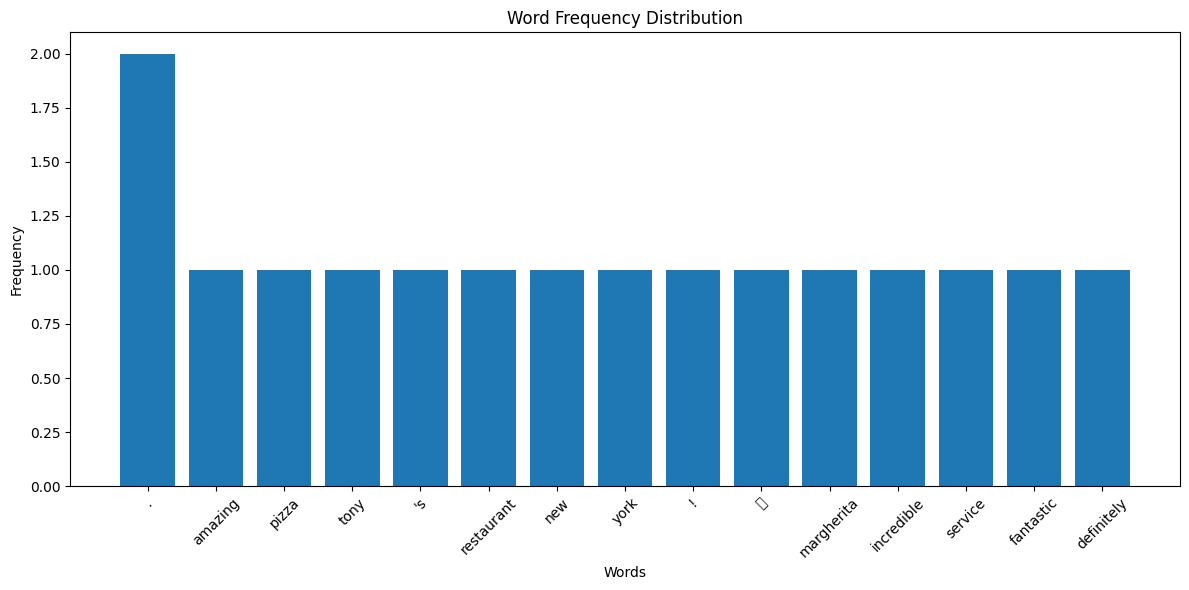

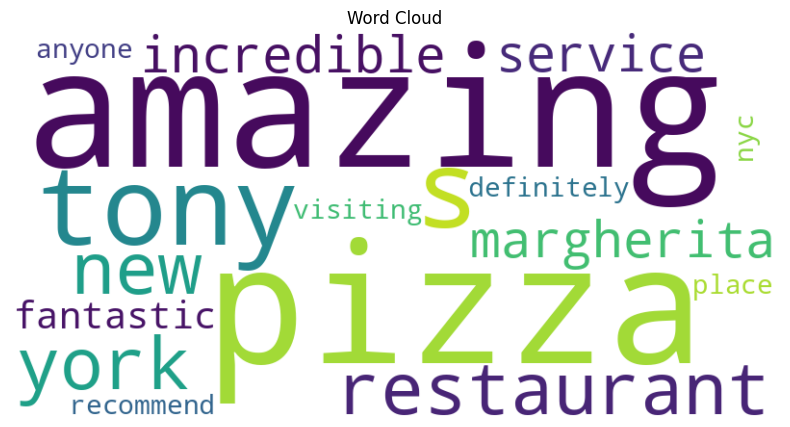


🔗 2-GRAM ANALYSIS
Most common 2-grams:
  amazing pizza: 1
  pizza tony: 1
  tony 's: 1
  's restaurant: 1
  restaurant new: 1

ANALYZING: ACADEMIC_TEXT

📈 WORD FREQUENCY ANALYSIS
Most common words:
  ,: 4
  language: 3
  .: 3
  human: 2
  natural: 1
  processing: 1
  (: 1
  nlp: 1
  ): 1
  subfield: 1
  artificial: 1
  intelligence: 1
  focuses: 1
  interaction: 1
  computers: 1


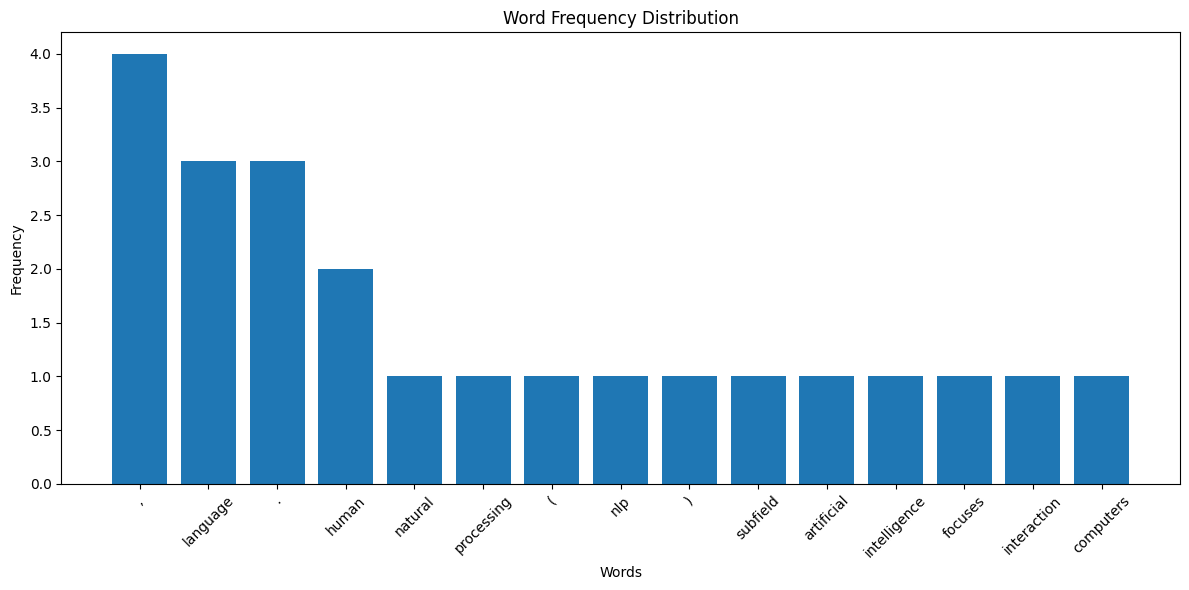

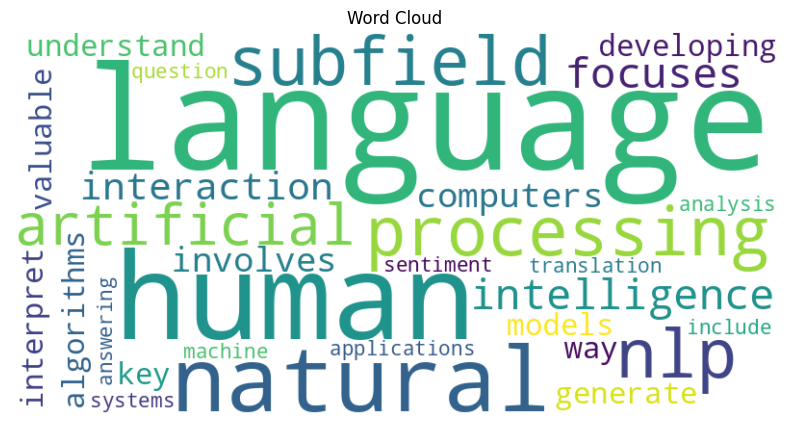


🔗 2-GRAM ANALYSIS
Most common 2-grams:
  human language: 2
  natural language: 1
  language processing: 1
  processing (: 1
  ( nlp: 1


In [15]:
# 5. FREQUENCY ANALYSIS
# =============================================================================

def analyze_word_frequency(text, top_n=15):
    """
    CONCEPT: Word Frequency Analysis
    - Identifies most common words
    - Shows vocabulary patterns
    """
    print(f"\n📈 WORD FREQUENCY ANALYSIS")
    print("="*50)

    # Preprocess text
    processed = preprocessor.preprocess_pipeline(
        text,
        ['clean', 'lowercase', 'tokenize', 'remove_stopwords']
    )
    tokens = processed['no_stopwords']

    # Word frequency
    word_freq = Counter(tokens)

    print(f"Most common words:")
    for word, count in word_freq.most_common(top_n):
        print(f"  {word}: {count}")

    # Visualize word frequency
    plt.figure(figsize=(12, 6))
    words, counts = zip(*word_freq.most_common(top_n))
    plt.bar(words, counts)
    plt.title('Word Frequency Distribution')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Generate word cloud
    if len(tokens) > 10:
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(tokens))
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('Word Cloud')
        plt.show()

    return word_freq

def analyze_ngrams(text, n=2, top_n=10):
    """
    CONCEPT: N-gram Analysis
    - Analyzes sequences of n words
    - Reveals common phrases and patterns
    """
    print(f"\n🔗 {n}-GRAM ANALYSIS")
    print("="*50)

    from nltk import ngrams

    # Preprocess text
    processed = preprocessor.preprocess_pipeline(
        text,
        ['clean', 'lowercase', 'tokenize', 'remove_stopwords']
    )
    tokens = processed['no_stopwords']

    # Generate n-grams
    n_grams = list(ngrams(tokens, n))
    ngram_freq = Counter(n_grams)

    print(f"Most common {n}-grams:")
    for ngram, count in ngram_freq.most_common(top_n):
        print(f"  {' '.join(ngram)}: {count}")

    return ngram_freq

# Analyze word frequency for all texts
for text_type, text in sample_texts.items():
    print(f"\n{'='*60}")
    print(f"ANALYZING: {text_type.upper()}")
    print(f"{'='*60}")

    word_freq = analyze_word_frequency(text)
    bigram_freq = analyze_ngrams(text, n=2, top_n=5)

In [16]:
# 6. TEXT STATISTICS AND READABILITY
# =============================================================================

def calculate_text_statistics(text):
    """
    CONCEPT: Text Statistics and Readability
    - Measures text complexity and readability
    - Provides insights into text difficulty
    """
    print(f"\n📊 TEXT STATISTICS")
    print("="*50)

    # Basic statistics
    sentences = preprocessor.tokenize_sentences(text)
    words = preprocessor.tokenize_words(text)
    characters = len(text)

    # Filter out punctuation for word count
    actual_words = [word for word in words if word.isalpha()]

    print(f"Basic Statistics:")
    print(f"  Characters: {characters}")
    print(f"  Words: {len(actual_words)}")
    print(f"  Sentences: {len(sentences)}")
    print(f"  Average words per sentence: {len(actual_words)/len(sentences):.1f}")
    print(f"  Average characters per word: {sum(len(word) for word in actual_words)/len(actual_words):.1f}")

    # Readability scores
    try:
        flesch_score = flesch_reading_ease(text)
        fk_grade = flesch_kincaid_grade(text)

        print(f"\nReadability Scores:")
        print(f"  Flesch Reading Ease: {flesch_score:.1f}")
        if flesch_score >= 90:
            level = "Very Easy"
        elif flesch_score >= 80:
            level = "Easy"
        elif flesch_score >= 70:
            level = "Fairly Easy"
        elif flesch_score >= 60:
            level = "Standard"
        elif flesch_score >= 50:
            level = "Fairly Difficult"
        elif flesch_score >= 30:
            level = "Difficult"
        else:
            level = "Very Difficult"
        print(f"    → Reading Level: {level}")

        print(f"  Flesch-Kincaid Grade: {fk_grade:.1f}")
        print(f"    → Grade Level: {int(fk_grade)}")
    except:
        print("  Could not calculate readability scores")

    # Vocabulary richness
    unique_words = set(word.lower() for word in actual_words)
    vocab_richness = len(unique_words) / len(actual_words)
    print(f"\nVocabulary Analysis:")
    print(f"  Unique words: {len(unique_words)}")
    print(f"  Vocabulary richness: {vocab_richness:.3f}")

    return {
        'characters': characters,
        'words': len(actual_words),
        'sentences': len(sentences),
        'vocab_richness': vocab_richness,
        'flesch_score': flesch_score if 'flesch_score' in locals() else None
    }

# Calculate statistics for all texts
stats_results = {}
for text_type, text in sample_texts.items():
    print(f"\n{'='*60}")
    print(f"STATISTICS FOR: {text_type.upper()}")
    print(f"{'='*60}")
    stats_results[text_type] = calculate_text_statistics(text)



STATISTICS FOR: NEWS_ARTICLE

📊 TEXT STATISTICS
Basic Statistics:
  Characters: 403
  Words: 53
  Sentences: 3
  Average words per sentence: 17.7
  Average characters per word: 5.6

Readability Scores:
  Flesch Reading Ease: 27.6
    → Reading Level: Very Difficult
  Flesch-Kincaid Grade: 12.9
    → Grade Level: 12

Vocabulary Analysis:
  Unique words: 45
  Vocabulary richness: 0.849

STATISTICS FOR: SOCIAL_MEDIA

📊 TEXT STATISTICS
Basic Statistics:
  Characters: 244
  Words: 33
  Sentences: 4
  Average words per sentence: 8.2
  Average characters per word: 5.5

Readability Scores:
  Flesch Reading Ease: 42.1
    → Reading Level: Difficult
  Flesch-Kincaid Grade: 9.4
    → Grade Level: 9

Vocabulary Analysis:
  Unique words: 29
  Vocabulary richness: 0.879

STATISTICS FOR: ACADEMIC_TEXT

📊 TEXT STATISTICS
Basic Statistics:
  Characters: 392
  Words: 47
  Sentences: 3
  Average words per sentence: 15.7
  Average characters per word: 6.2

Readability Scores:
  Flesch Reading Ease: 5.5
 

In [17]:
# 7. COMPREHENSIVE TEXT ANALYSIS FUNCTION
# =============================================================================

def comprehensive_text_analysis(text, text_name="Sample Text"):
    """
    Combines all NLP techniques into one comprehensive analysis
    """
    print(f"\n{'='*80}")
    print(f"COMPREHENSIVE ANALYSIS: {text_name.upper()}")
    print(f"{'='*80}")

    results = {}

    # 1. Preprocessing
    print("1. TEXT PREPROCESSING")
    print("-" * 30)
    processed = preprocessor.preprocess_pipeline(text)
    results['preprocessing'] = processed

    # 2. Tokenization
    print("\n2. TOKENIZATION")
    print("-" * 30)
    sentences, words = analyze_tokenization(text)
    results['tokenization'] = {'sentences': sentences, 'words': words}

    # 3. POS Tagging
    print("\n3. PART-OF-SPEECH TAGGING")
    print("-" * 30)
    pos_tags = analyze_pos_tags(text)
    results['pos_tags'] = pos_tags

    # 4. Named Entity Recognition
    print("\n4. NAMED ENTITY RECOGNITION")
    print("-" * 30)
    entities = analyze_named_entities(text)
    results['entities'] = entities

    # 5. Frequency Analysis
    print("\n5. FREQUENCY ANALYSIS")
    print("-" * 30)
    word_freq = analyze_word_frequency(text, top_n=10)
    results['word_frequency'] = word_freq

    # 6. Text Statistics
    print("\n6. TEXT STATISTICS")
    print("-" * 30)
    stats = calculate_text_statistics(text)
    results['statistics'] = stats

    return results

In [18]:
# 8. INTERACTIVE ANALYSIS
# =============================================================================

print("\n🎯 READY FOR INTERACTIVE ANALYSIS!")
print("="*60)
print("You can now:")
print("1. Analyze any of the sample texts using: comprehensive_text_analysis(sample_texts['news_article'])")
print("2. Try with your own text: comprehensive_text_analysis('Your text here', 'My Text')")
print("3. Use individual functions for specific analysis")
print("4. Experiment with different preprocessing steps")

# Example of how to use with your own text
print("\n📝 Example: Analyze your own text")
print("-" * 40)
your_text = """
Machine learning is transforming industries across the globe. From healthcare to finance,
AI systems are helping companies make better decisions and improve customer experiences.
However, ethical considerations and data privacy remain important challenges that need to be addressed.
"""

# Uncomment the line below to run comprehensive analysis on the example text
# comprehensive_analysis_results = comprehensive_text_analysis(your_text, "Custom Example")

print("\n✅ NLP Fundamentals Project Complete!")
print("You've learned the core concepts of:")
print("- Text preprocessing and cleaning")
print("- Tokenization (sentences and words)")
print("- Part-of-speech tagging")
print("- Named entity recognition")
print("- Frequency analysis and n-grams")
print("- Text statistics and readability")
print("\nThese fundamentals prepare you for advanced NLP techniques like transformers!")


🎯 READY FOR INTERACTIVE ANALYSIS!
You can now:
1. Analyze any of the sample texts using: comprehensive_text_analysis(sample_texts['news_article'])
2. Try with your own text: comprehensive_text_analysis('Your text here', 'My Text')
3. Use individual functions for specific analysis
4. Experiment with different preprocessing steps

📝 Example: Analyze your own text
----------------------------------------

✅ NLP Fundamentals Project Complete!
You've learned the core concepts of:
- Text preprocessing and cleaning
- Tokenization (sentences and words)
- Part-of-speech tagging
- Named entity recognition
- Frequency analysis and n-grams
- Text statistics and readability

These fundamentals prepare you for advanced NLP techniques like transformers!
